In [1]:
import os
os.chdir('..')

# Packages

In [2]:
from nlp import preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
from sklearn.preprocessing import normalize # normalization for sparse matrices

# Read in Small Data (metadata)

In [4]:
metadata = pd.read_csv('big_data/metadata.csv')
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)

Using the search query to focus on abstracts:
"COVID-19" OR Coronavirus OR "Corona virus" OR "2019-nCoV" OR "SARS-CoV" OR "MERS-CoV" OR “Severe Acute Respiratory Syndrome” OR “Middle East Respiratory Syndrome” 

In [5]:
 metadata = metadata[metadata['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         metadata['abstract'].str.contains("MERS")
         ]

In [6]:
count = sum(metadata['abstract'].str.contains('COVID'))
print('There are ' + str(count) + ' articles mentioning COVID, which likely refers to COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19'))
print('There are ' + str(count) + ' articles mentioning COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19')[(pd.isnull(metadata['abstract']) == False) & 
                                                          (metadata['abstract'].str.contains('COVID-19'))
                                                         ] 
           )
print('There are ' + str(count) + ' articles mentioning COVID and COVID-19.')

There are 899 articles mentioning COVID, which likely refers to COVID-19.
There are 881 articles mentioning COVID-19.
There are 881 articles mentioning COVID and COVID-19.


In [7]:
covid_article_indexes = np.argwhere(metadata['abstract'].str.contains('COVID')).T[0]

C:\Users\vldoa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


# Traditional ML

## Preprocessing

Preprocess text

In [8]:
t = time.time()
preprocessor = preprocessing.Preprocessor(metadata['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)
print(time.time() - t)

57.80501627922058


Preprocess for bigrams

In [9]:
preprocessor.get_bigrams_from_preprocessed()

Create key NLP objects for word counts

In [10]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 canin_coronavirus
1 common
2 competit_elisa
3 describ
4 direct
5 epitop
6 felin
7 peplom_protein
8 relat
9 tgev_prcv
10 util

 98405 unique words. 

20125 unique words after extremes filtered. 


Word 0 ("canin_coronavirus") appears 1 time.
Word 3 ("describ") appears 1 time.
Word 4 ("direct") appears 1 time.
Word 8 ("relat") appears 1 time.
Word 17 ("coronavirus") appears 1 time.
Word 19 ("detect") appears 2 time.
Word 27 ("increas") appears 1 time.
Word 33 ("respiratori") appears 1 time.
Word 41 ("virus") appears 1 time.
Word 48 ("bind") appears 1 time.
Word 89 ("result") appears 1 time.
Word 95 ("strain") appears 1 time.
Word 116 ("fluoresc") appears 4 time.
Word 121 ("label") appears 1 time.
Word 133 ("activ") appears 1 time.
Word 135 ("complet") appears 1 time.
Word 145 ("high") appears 2 time.
Word 149 ("initi") appears 1 time.
Word 230 ("transmiss_gastroenter") appears 1 time.
Word 283 ("develop") appears 1 time.
Word 285 ("extens") appears 1 time.
Word 326 ("indic") appears 1 

## PCA

## Implementation

In [11]:
tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

(0, 1.01)

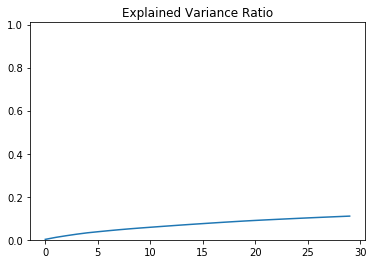

In [12]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)

transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)

plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:30])
plt.ylim(0, 1.01)

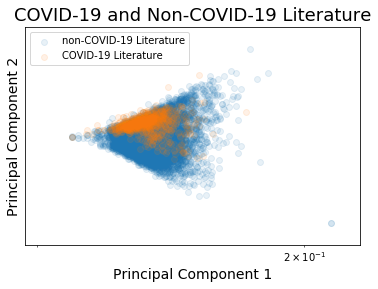

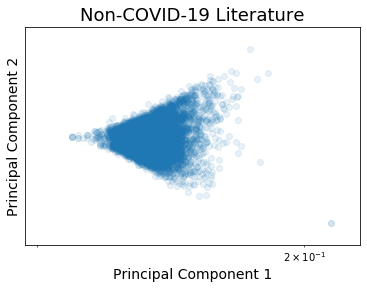

In [13]:
xscale_log_addition = 0.1

not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1, label='non-COVID-19 Literature')

plt.scatter(transformed[covid_article_indexes,0] + xscale_log_addition,
            transformed[covid_article_indexes,1], alpha=0.1, label='COVID-19 Literature')
# plt.yscale('log')
plt.xscale('log')
plt.title('COVID-19 and Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.xticks([]); plt.yticks([])
plt.legend()
plt.show()




not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1)
# plt.yscale('log')
plt.xscale('log')
plt.title('Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.xticks([]); plt.yticks([])
# plt.legend()
plt.show()

<IPython.core.display.Javascript object>


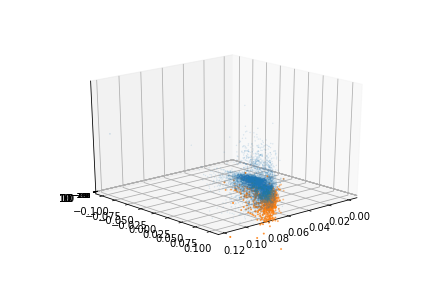

In [22]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook




import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed[not_covid,0], transformed[not_covid,1], transformed[not_covid,2], s=0.1, alpha=0.2)
ax.scatter(transformed[covid_article_indexes,0], transformed[covid_article_indexes,1],
           transformed[covid_article_indexes,2], s=1)

# ax.xscale('log')
ax.set_zscale('log')
# ax.set_yscale('log')

## Analysis

In [43]:
def get_top_words_and_scores(svd, dictionary, c, n, visual=True):
    word_ids_sorted = np.argsort(np.abs(svd.components_[c]))[::-1]
    top_words_and_scores = [[dictionary[word_ids_sorted[i]], svd.components_[c, word_ids_sorted[i]]] for i in range(n)]
    top_words_and_scores = pd.DataFrame(
        top_words_and_scores,columns=['word', 'component_score']).sort_values('component_score')
    
    if visual:
        %matplotlib inline
        %matplotlib inline

        plt.figure(figsize=(18,5))
        plt.bar(height=top_words_and_scores['component_score'], x=top_words_and_scores['word'])
        plt.xticks(rotation=50)
        plt.xlabel("Lemmatized Word", size=14)
        plt.ylabel("Component " + str(c + 1) + ' Value', size=14)
        plt.title("Top " + str(n) + " Words' Values of a Principal Component")
        plt.show()
    
    
    return top_words_and_scores

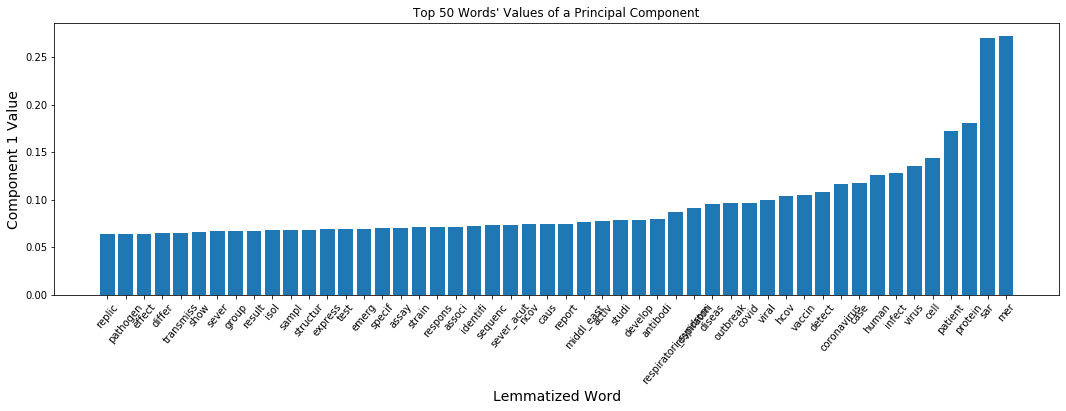

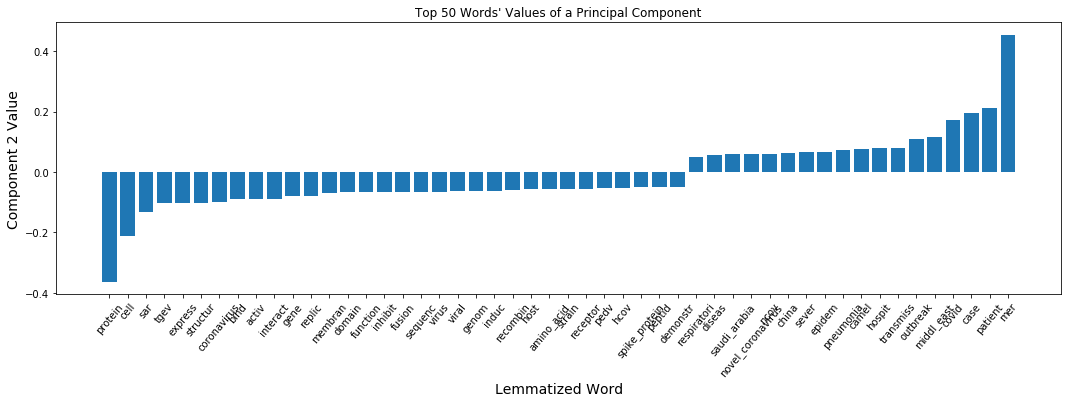

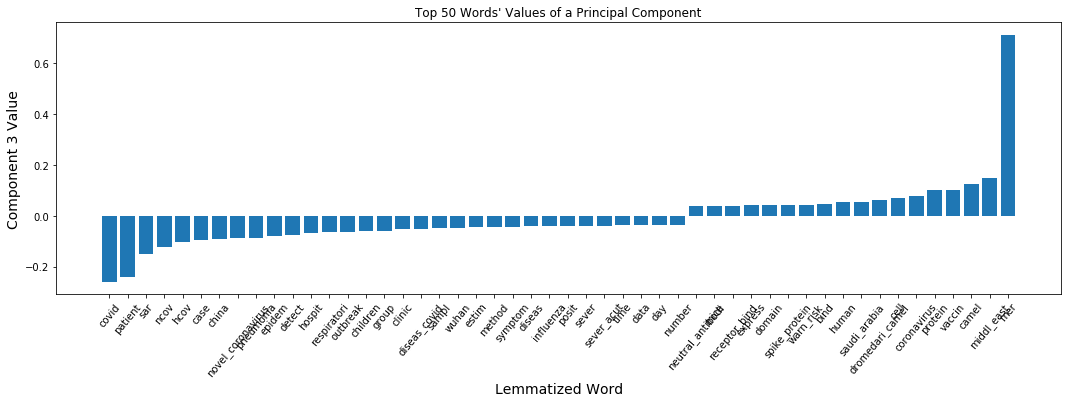

In [45]:
for i in range(3):
    top_words_and_scores = get_top_words_and_scores(truncatedsvd, dictionary, i, 50, visual=True)
    plt.show()

In [42]:
metadata['component_0'] = transformed[:,0] * 10**6
metadata['component_1'] = transformed[:,1] * 10**6

metadata['component_0_percentile'] = metadata['component_0'].rank(pct=True)
metadata['component_1_percentile'] = metadata['component_1'].rank(pct=True)

In [22]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

In [23]:
metadata.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'gensim_abstract_processed', 'component_0',
       'component_1', 'component_0_percentile', 'component_1_percentile',
       'abstract_COVID'],
      dtype='object')

In [26]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_0', 'component_1', 'component_0_percentile', 'component_1_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed_subsetted.csv', sep='|', index=False)

In [25]:
metadata_small

,title,doi,pmcid,pubmed_id,abstract,publish_time,journal,component_0,component_1,component_0_percentile,component_1_percentile,abstract_COVID
27,An ELISA for the detection of serum antibodies...,10.1016/0007-1935(91)90010-K,NaN,1717102.0,Abstract A competition ELISA utilizing a mAb d...,1991-08-31,British Veterinary Journal,28078.244875,-25991.317997,0.629795,0.070029,False
29,Equine arteritis virus: An overview,10.1016/0007-1935(92)90044-2,NaN,1319787.0,Abstract The causative agent of the respirator...,1992-06-30,British Veterinary Journal,16745.907037,-1347.118295,0.090674,0.485630,False
33,Morphology and morphogenesis of a coronavirus ...,10.1016/0014-4800(76)90045-9,NaN,187445.0,Abstract The morphology and morphogenesis of v...,1976-12-31,Experimental and Molecular Pathology,13009.131458,-10803.307786,0.027683,0.329032,False
37,Bovine coronavirus antigen in the host cell pl...,10.1016/0014-4800(90)90039-G,NaN,2261945.0,Abstract Expression of bovine coronavirus (BCV...,1990-10-31,Experimental and Molecular Pathology,24166.605906,-22515.423680,0.422287,0.118827,False
44,Endosomal association of a protein phosphatase...,10.1016/0014-5793(91)80528-B,NaN,1674698.0,Abstract On the assumption that dephosphorylat...,1991-05-06,FEBS Letters,15406.657609,-13085.320712,0.061466,0.289150,False
45,Putative papain-related thiol proteases of pos...,10.1016/0014-5793(91)81034-6,NaN,1652473.0,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,27325.691087,-23172.722637,0.592962,0.107801,False
51,Influence of coronavirus (transmissible gastro...,10.1016/0016-5085(84)90717-0,NaN,6735081.0,Abstract Four silver—silver chloride electrode...,1984-08-31,Gastroenterology,12194.055505,-780.353176,0.021701,0.495249,False
57,An in-depth study of Crohn's disease in two Fr...,10.1016/0016-5085(93)90401-W,NaN,8425677.0,Abstract Background: Two French families were ...,1993-02-28,Gastroenterology,17792.343482,4961.152465,0.120000,0.591202,False
67,The pathogenesis of nephritis in chickens indu...,10.1016/0021-9975(82)90078-0,NaN,6282945.0,Abstract Nephritis in chickens caused by infec...,1982-04-30,Journal of Comparative Pathology,12416.720750,-4927.540206,0.023226,0.425806,False
76,Pathogenicity and antigen detection of the Nou...,10.1016/0021-9975(92)90068-6,NaN,1313460.0,Abstract We compared the pathogenicity and the...,1992-01-31,Journal of Comparative Pathology,14596.154901,-6387.774775,0.046217,0.404106,False
